# Fluxomics Analysis

The script that generates the enrichment analysis of the TCA cycle intermediates normalised to the extracellular glucose fraction. If the measured value reaches 1 that means that the metabolite is both a) at a steady-state labelling, and b) completely derived from glucose.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [14]:
reactor_cell_line = {
    "CS1-1": "CHO-S wt", 
    "CS1-2": "CHO-S wt", 
    "CS1-3": "CHO-S wt", 
    "CS1-4": "CHO-S wt", 
    "CS1-5": "CHO-ZeLa", 
    "CS1-6": "CHO-ZeLa", 
    "CS1-7": "CHO-ZeLa", 
    "CS1-8": "CHO-ZeLa"
}
color_map = {"CHO-S wt": "#2767C5", "CHO-ZeLa": "#BB261A"}
time_map = {"t0": 0, "t1": 2, "t2": 4, "t3": 8, "t4": 14}
data = pd.read_csv("Results_17_11_23.csv")
data["component"] = data.apply(lambda x: x["Component Name"].split("_")[1], axis=1)
data["reactor"] = data.apply(lambda x: x["Sample Name"].split("_")[1], axis=1)
data["time"] = data.apply(lambda x: time_map[x["Sample Name"].split("_")[2]], axis=1)
data["num_carbons"] = data["component"].apply(lambda x: x.split("-")[0][-1])

In [15]:
data['Component Group Name'].unique()

array(['pyr', 'succ', 'mal-L', 'akg', 'acon-C', 'icit', 'oaa'],
      dtype=object)

## Determining extracellular labelling fraction to determine fraction
The labelling of metabolites is determined by the extracellular labeling fraction. Due to the method there will be a different fraction of label for each reactor. We account for this by dividing the intracellular pools by the fraction of extracellular glucose.

In [4]:
extracellular_carbon_labelling = pd.read_csv("extracellular_labelling_mvd.csv")
extracellular_carbon_labelling["reactor"] = extracellular_carbon_labelling["Label"].apply(lambda x: "CS1-" + x.split("_")[0][-1])
extracellular_labelled_fraction = extracellular_carbon_labelling[["reactor", "5"]].groupby("reactor").mean().reset_index().set_index("reactor")

In [5]:
extracellular_labelled_fraction

,5
reactor,
CS1-1,0.417836
CS1-2,0.439221
CS1-3,0.421750
CS1-4,0.420956
CS1-5,0.393513
CS1-6,0.396003
CS1-7,0.388883
CS1-8,0.392793


In [6]:
samples = data["Sample Name"].unique()
groups = data["Component Group Name"].unique()
reference = "m0-0"
processed_data = list()
for sample in samples:
    for group in groups:
        sample_group = data[(data["Sample Name"]==sample) & (data["Component Group Name"] == group)].copy()
        sample_group.loc[:,"atom_frac"] = sample_group["num_carbons"].astype(float)/sample_group["num_carbons"].astype(float).max()
        sample_group.loc[:,"fraction"] = (sample_group.Area.values / sample_group.Area.sum())
        reactor = sample_group.reactor.unique()[0]
        ex_fraction_labelled = extracellular_labelled_fraction.loc[reactor]["5"]
        fraction_labelled = (sample_group.fraction * sample_group.atom_frac).sum()/ex_fraction_labelled
        processed_data.append(
            {
                "reactor": reactor,
                "time": sample_group.time.unique()[0],
                "group": group,
                "fraction_labelled": fraction_labelled
            }
        )

processed_data_df = pd.DataFrame.from_records(processed_data)
processed_data_df["cell_line"] = processed_data_df["reactor"].map(reactor_cell_line)
processed_data_df["color"] = processed_data_df["cell_line"].map(color_map)

## Significance determined by p<0.05

In [7]:
significance = []
for time in processed_data_df["time"].unique():
    for group in processed_data_df["group"].unique():
        comp_timepoint = processed_data_df[(processed_data_df["time"]==time) & (processed_data_df["group"]==group)]
        zela_ct = comp_timepoint[comp_timepoint["cell_line"]=="CHO-ZeLa"].copy()["fraction_labelled"]
        wt_ct = comp_timepoint[comp_timepoint["cell_line"]=="CHO-S wt"].copy()["fraction_labelled"]
        res = stats.ttest_ind(zela_ct, wt_ct, equal_var=False)
        significance.append({"time": time, "group": group, "pval": res.pvalue})

significance_df = pd.DataFrame.from_records(significance)
signifinicant_diff = significance_df[significance_df["pval"]<0.05].reset_index(drop=True)

In [8]:
signifinicant_diff

,time,group,pval
0,0,pyr,3.924402e-08
1,0,succ,4.258969e-03
2,0,mal-L,1.065318e-02
3,0,akg,1.610522e-03
4,2,pyr,3.907944e-07
5,2,succ,1.947664e-04
6,2,mal-L,1.574648e-04
7,2,akg,2.623145e-02
8,2,acon-C,3.311484e-02
9,2,icit,6.095699e-03


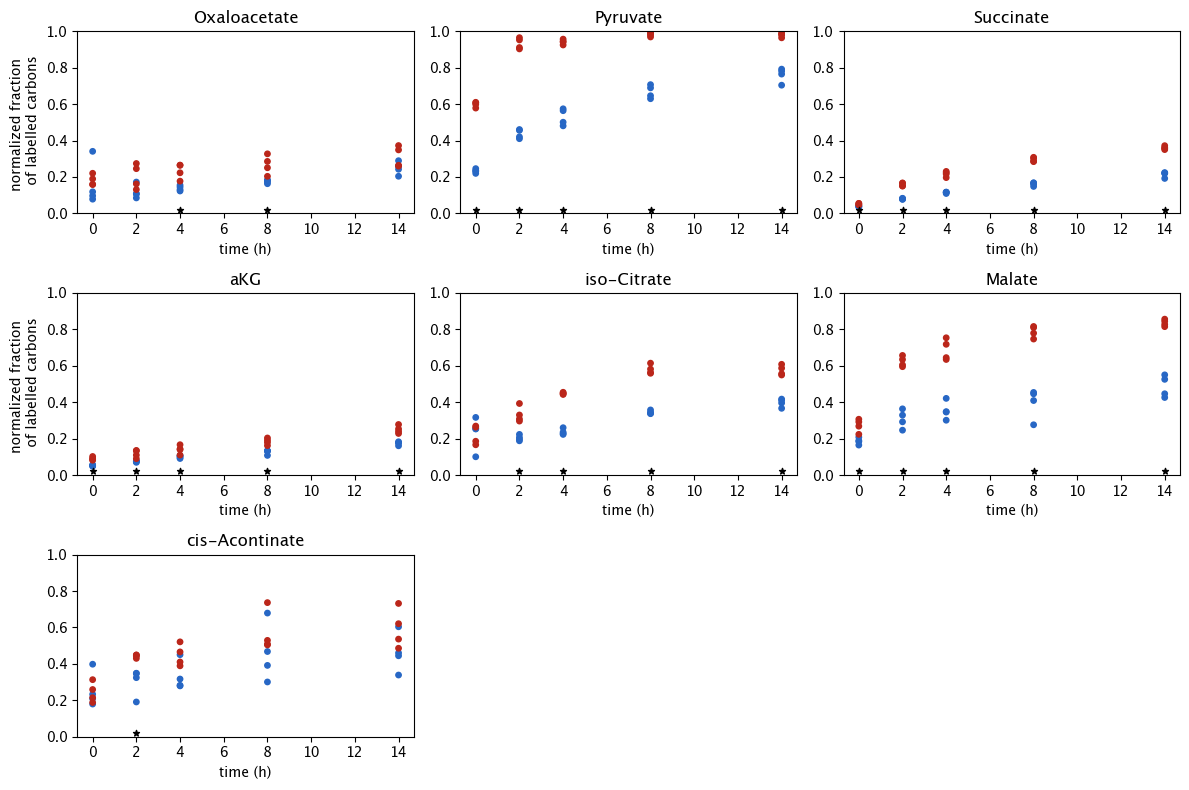

In [11]:
met_dict = {"oaa": "Oxaloacetate", "pyr": "Pyruvate", "succ": "Succinate", "akg": "aKG", "icit": "iso-Citrate", "mal-L": "Malate", "acon-C": "cis-Acontinate"}
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
for ax, met in zip(axes.flatten(), met_dict.keys()):
    subplot_data = processed_data_df[processed_data_df["group"]==met]
    sig_points = signifinicant_diff[signifinicant_diff["group"]==met].reset_index(drop=True).copy()
    mean_value = subplot_data[["time", "fraction_labelled"]].groupby(["time"]).mean().reset_index()
    for idx, sig_point in sig_points.iterrows():
        if mean_value[mean_value["time"]==sig_point.time].fraction_labelled.values[0]>0.5:
            sig_points.loc[idx,"marker"] = 0.02
        else:
            sig_points.loc[idx,"marker"] = 0.02

    ax.scatter(
        x=subplot_data["time"],
        y=subplot_data["fraction_labelled"],
        color=subplot_data["color"],
        s=15,
    )
    ax.set_title(met_dict[met])
    ax.scatter(
        x=sig_points["time"],
        y=sig_points["marker"],
        color="black",
        s=20,
        marker="*"
    )
    ax.set_ylim([0,1])
    ax.set_xlabel("time (h)")
    
for ax in axes.flatten()[len(met_dict):]:
    ax.set_visible(False)


axes[0,0].set_ylabel("normalized fraction \n of labelled carbons")
axes[1,0].set_ylabel("normalized fraction \n of labelled carbons")
fig.tight_layout()
#fig.savefig("labelling_fractions.png")